In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

from PIL import Image

/home/jjc/miniconda3/envs/dllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


/home/jjc/miniconda3/envs/dllm/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:604: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


[2025-05-25 09:17:40,403] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/jjc/miniconda3/envs/dllm/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/jjc/miniconda3/envs/dllm/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


In [3]:
model_path = "/data1/ckpts/deepseek-ai_/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = MultiModalityCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


In [5]:
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor


# specify the path to the model
model_path = "/data1/ckpts/deepseek-ai_/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

conversation = [
    {
        "role": "<|User|>",
        "content": "A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair",
    },
    {"role": "<|Assistant|>", "content": ""},
]

sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_start_tag


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 16,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state
        
        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]
        
        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)


generate(
    vl_gpt,
    vl_chat_processor,
    prompt,
)

In [2]:
from omegaconf import OmegaConf
from util.dataloader import get_dataloader
from janus.models import MultiModalityCausalLM, VLChatProcessor

config = OmegaConf.load("config/janus_gen.yaml")
dataloader = get_dataloader(config.data)

janus = MultiModalityCausalLM.from_pretrained("/data1/ckpts/deepseek-ai_/Janus-Pro-1B", trust_remote_code=True)
vl_chat_processor = VLChatProcessor.from_pretrained("/data1/ckpts/deepseek-ai_/Janus-Pro-1B")


/home/jjc/miniconda3/envs/dllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


/home/jjc/miniconda3/envs/dllm/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:604: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


[2025-05-25 11:17:54,175] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/jjc/miniconda3/envs/dllm/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/jjc/miniconda3/envs/dllm/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why t

In [13]:
import torch
dtype = torch.float32
device = "cpu"
for batch in dataloader:
    janus.train()
    text = batch["texts"]

    pixel_values = batch["pixel_values"].to(dtype)
    img_embeddings = janus.aligner(janus.vision_model(pixel_values))
    joint_embeddings = []
    # img_masks = []
    B = pixel_values.shape[0]

    for i, input_ids in enumerate(text):
        input_ids = torch.cat([input_ids, torch.tensor([100003], device=device)])
        # if input_ids.shape[0] > 150:
        #     continue
        text_embedding = janus.language_model.get_input_embeddings()(input_ids).unsqueeze(0)                    
        img_embedding = img_embeddings[i].unsqueeze(0)
        joint_embedding = torch.cat((text_embedding, img_embedding), dim=1)
        # num_padding = 150 + 576 - joint_embedding.shape[1]
        # joint_embedding = torch.cat((joint_embedding, torch.zeros((1, num_padding, 2048), device=device)), dim=1)
        
        # img_mask = torch.zeros(1, joint_embedding.shape[1], dtype=torch.bool, device=device)
        print("text_embedding", text_embedding.shape)
        # img_mask[:, text_embedding.shape[1]:text_embedding.shape[1]+576] = 1
        # img_masks.append(img_mask)
        joint_embeddings.append(joint_embedding)
    joint_embeddings = torch.cat(joint_embeddings, dim=0)
    # img_masks = torch.cat(img_masks, dim=0)
    break

    # print(joint_embeddings.dtype)
    output = janus.language_model(
        inputs_embeds=joint_embeddings.to(dtype),
        attention_mask=None,
        output_hidden_states=True,
    ).hidden_states[-1]

    # Create a copy tensor with the same shape as output but filled with zeros
    # masked_output = torch.zeros_like(output)
    # # Only fill values where padding_masks is True
    # masked_output[padding_masks] = output[padding_masks]
    print(output.shape, output[output].shape)


torch.Size([150])
torch.Size([150])
text_embedding torch.Size([1, 151, 2048])
text_embedding torch.Size([1, 151, 2048])


In [95]:
vl_chat_processor.tokenizer(["<begin_of_image>"], return_tensors="pt").input_ids[0]

tensor([100000, 100003])

'<｜▁pad▁｜>'

In [9]:
vl_chat_processor.tokenizer(vl_chat_processor.pad_tag)

{'input_ids': [100000, 100002], 'attention_mask': [1, 1]}

In [44]:
import torch
# Tokenize each text in the batch
# tokenized_texts = []
pixel_values = vl_chat_processor.image_processor(img, return_tensors="pt").pixel_values
img_embeddings = janus.aligner(janus.vision_model(pixel_values))
print(img_embeddings.shape)

joint_embeddings = []
for i, single_text in enumerate(text):
    single_text += vl_chat_processor.image_start_tag
    input_ids = vl_chat_processor.tokenizer(single_text, return_tensors="pt").input_ids[0]
    print(vl_chat_processor.tokenizer.decode(input_ids, skip_special_tokens=False))
    if input_ids.shape[0] > 150:
        break
    text_embedding = janus.language_model.get_input_embeddings()(input_ids).unsqueeze(0)
    
    
    img_embedding = img_embeddings[i].unsqueeze(0)
    joint_embedding = torch.cat((text_embedding, img_embedding), dim=1)
    num_padding = 150 + 576 - joint_embedding.shape[1]
    # print(joint_embedding.shape, num_padding)
    joint_embedding = torch.cat((joint_embedding, torch.zeros(1, num_padding, 2048)), dim=1)

    padding_mask = torch.ones(1, joint_embedding.shape[1], dtype=torch.bool)
    padding_mask[:, -num_padding:] = 0
    joint_embeddings.append(joint_embedding)
    print(joint_embedding.shape)
    # print(padding_mask)

    print(joint_embedding[padding_mask].shape)

joint_embeddings = torch.cat(joint_embeddings, dim=0)
# tokenized_texts = torch.stack(tokenized_texts)
# Display the first tokenized text
# print("First tokenized text:")
# print(f"Input IDs shape: {tokenized_texts[0].input_ids.shape}")
# print(f"Input IDs: {tokenized_texts[:10]}... (truncated)")
# print(f"Attention mask: {tokenized_texts[0].attention_mask[0][:10]}...")

torch.Size([2, 576, 2048])
<｜begin▁of▁sentence｜>The image depicts a person in military attire, including a helmet and tactical gear, running through a grassy field dotted with yellow flowers. The individual appears to be in motion, possibly during a training exercise or a tactical operation. The background shows a mix of greenery and a dirt path, suggesting an open outdoor setting. The person's posture and the way they are holding their hands up might indicate a gesture of surrender or signaling. The overall scene conveys a sense of action and movement in a natural environment.<begin_of_image>
torch.Size([1, 726, 2048])
torch.Size([678, 2048])
<｜begin▁of▁sentence｜>The image captures a picturesque coastal scene with a clear blue sky and scattered clouds. In the foreground, a calm body of water reflects the serene atmosphere. A dock extends into the water, with a flagpole and a small structure at its end. Beyond the dock, a marina is visible, filled with various boats and yachts moored a

In [45]:
joint_embeddings.shape

torch.Size([2, 726, 2048])

In [55]:
inputs_embeds = janus.language_model.get_input_embeddings()(tokenized_texts)

TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not list

In [44]:
vision_model = janus.vision_model.to("cuda:1")
img_embed = vision_model(pixel_values.to("cuda:1"))
print(img_embed.shape)

torch.Size([5, 576, 1024])


In [17]:
text

['The image showcases the top of a grand building, featuring a large, glass-covered dome with a ribbed structure. Atop the dome sits an ornate golden statue of a winged figure, possibly an angel or a mythological being, holding a staff or scepter. The statue is perched on a golden sphere, adding to the opulent appearance. The architecture suggests a classical style, with intricate details and a sense of historical significance. The sky in the background is overcast, giving the scene a somewhat muted yet majestic atmosphere. The overall composition highlights the architectural beauty and the symbolic importance of the golden statue.',
 "The image depicts an airport scene with a red and white airplane taxiing on a runway. The aircraft is positioned centrally in the frame, moving towards the camera. In the background, there is a control tower and a series of buildings, likely part of the airport infrastructure. The surrounding area includes greenery and trees, indicating a well-maintained

In [22]:
# Create a list to store prompts for each item in the batch
batch_prompts = []

# Process each text in the batch
for single_text in text:
    conversation = [
        {
            "role": "<|User|>",
            "content": single_text,  # Use the text from the batch
        },
        {"role": "<|Assistant|>", "content": ""},
    ]
    
    # Format the conversation
    sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
        conversations=conversation,
        sft_format=vl_chat_processor.sft_format,
        system_prompt="",
    )
    
    # Add image start tag
    prompt = sft_format + vl_chat_processor.image_start_tag
    batch_prompts.append(prompt)

# Now batch_prompts contains formatted prompts for each text in the batch

In [23]:
batch_prompts

['<|User|>: The image showcases the top of a grand building, featuring a large, glass-covered dome with a ribbed structure. Atop the dome sits an ornate golden statue of a winged figure, possibly an angel or a mythological being, holding a staff or scepter. The statue is perched on a golden sphere, adding to the opulent appearance. The architecture suggests a classical style, with intricate details and a sense of historical significance. The sky in the background is overcast, giving the scene a somewhat muted yet majestic atmosphere. The overall composition highlights the architectural beauty and the symbolic importance of the golden statue.\n\n<|Assistant|>:<begin_of_image>',
 "<|User|>: The image depicts an airport scene with a red and white airplane taxiing on a runway. The aircraft is positioned centrally in the frame, moving towards the camera. In the background, there is a control tower and a series of buildings, likely part of the airport infrastructure. The surrounding area inc

In [25]:
for prompt in batch_prompts:
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    break
# input_ids = torch.LongTensor(input_ids)

In [ ]:
from omegaconf import OmegaConf
from util.dataloader import get_dataloader
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor


# specify the path to the model
model_path = "/data1/ckpts/deepseek-ai_/Janus-Pro-1B"
vl_chat_processor = VLChatProcessor.from_pretrained(model_path)

config = OmegaConf.load("config/janus_gen.yaml")
dataloader = get_dataloader(config.data)
for batch in dataloader:
    texts = batch["texts"]
    pixel_values = batch["pixel_values"]
    break

In [24]:
B = texts.shape[0]
mask = torch.rand(B, 1) < 0.3
mask = mask.repeat(1, 150)
texts[mask] = vl_chat_processor.pad_id
texts[:, 0] = 100000 # recover the <｜begin▁of▁sentence｜>

texts


tensor([[100000, 100002, 100002,  ..., 100002, 100002, 100002],
        [100000,    549,   3324,  ..., 100002, 100002, 100002],
        [100000,    549,   3324,  ..., 100002, 100002, 100002],
        ...,
        [100000,    549,   3324,  ..., 100002, 100002, 100002],
        [100000,    549,   3324,  ..., 100002, 100002, 100002],
        [100000, 100002, 100002,  ..., 100002, 100002, 100002]])

In [25]:
vl_chat_processor.pad_id

100002

In [26]:
import torch
vl_chat_processor.tokenizer.decode(torch.tensor([100003]))


'<begin_of_image>'

In [4]:

import torch
from PIL import Image
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

# specify the path to the model
model_path = "/data1/ckpts/deepseek-ai_/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
ckpt = torch.load("/data1/jjc/experiment/bi_tok/0526_janus_gen_32_trainlm/janus-bi_tok-15k", map_location="cpu")
vl_gpt.language_model.load_state_dict(ckpt, strict=True)
vl_gpt = vl_gpt.to(torch.bfloat16).to(5).eval()

question = "Describe the image in detail."
image = "/data1/LargeData/ImageNet/val/n13133613/ILSVRC2012_val_00010376.JPEG"

conversation = [
    {
        "role": "<|User|>",
        "content": f"<image_placeholder>\n{question}",
        "images": [image],
    },
    {"role": "<|Assistant|>", "content": ""},
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

# # run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# # run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)


You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

<|User|>: <image_placeholder>
Describe the image in detail.

<|Assistant|>: The image shows outdoor outdoor环境 outdoors weather conditions下雨天气雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋雨水淋

In [17]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = []
    texts = []
    for sample in batch:
        img = sample["jpg"]
        text = sample["txt"]

        input_ids = vl_chat_processor.tokenizer(text, return_tensors="pt").input_ids[0]
        if input_ids.shape[0] > 50:
            continue

        pixel_values.append(vl_chat_processor.image_processor([img], return_tensors="pt").pixel_values)

        input_ids = torch.cat([input_ids, 100002 * torch.ones(50 - input_ids.shape[0], dtype=torch.long)], dim=0)
        texts.append(input_ids)
        
    pixel_values = torch.cat(pixel_values, dim=0)
    texts = torch.stack(texts, dim=0)

    return {"pixel_values": pixel_values, "texts": texts}

def collate_fn_new(batch):
    # print(batch)
    imgs = [sample["jpg"] for sample in batch]
    texts = [sample["txt"] for sample in batch]
    pixel_values = vl_chat_processor.image_processor(imgs, return_tensors="pt").pixel_values
    input_ids = vl_chat_processor.tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=64).input_ids

    # print(pixel_values.shape, input_ids.shape)
    # pixel_values = []
    # texts = []
    # for sample in batch:
    #     img = sample["jpg"]
    #     text = sample["txt"]

    #     input_ids = vl_chat_processor.tokenizer(text, return_tensors="pt").input_ids[0]
    #     if input_ids.shape[0] > 50:
    #         continue

    #     pixel_values.append(vl_chat_processor.image_processor([img], return_tensors="pt").pixel_values)

    #     input_ids = torch.cat([input_ids, 100002 * torch.ones(50 - input_ids.shape[0], dtype=torch.long)], dim=0)
    #     texts.append(input_ids)
        
    # pixel_values = torch.cat(pixel_values, dim=0)
    # texts = torch.stack(texts, dim=0)

    return {"pixel_values": pixel_values, "texts": input_ids}


In [26]:
from omegaconf import OmegaConf
from util.dataloader import get_dataloader
config = OmegaConf.load("config/janus_gen.yaml")
dataloader = get_dataloader(config.data)

Setting num_proc from 128 to 36 for the train split as it only contains 36 shards.
Generating train split: 360000 examples [02:25, 2472.91 examples/s]


In [27]:
for batch in dataloader:
    pixel_values = batch["pixel_values"]
    texts = batch["texts"]
    attention_mask = batch["attention_mask"]
    break


In [28]:
texts[1]

tensor([100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002,
        100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002,
        100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002,
        100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002,
        100002, 100002, 100002, 100002, 100002, 100000,     32,  42463,  13844,
         31292,  22805,  16783,     13])

In [32]:
# attention_mask.shape
import torch
img_mask = torch.ones((pixel_values.shape[0], 1 + 576), dtype=torch.bool)
attention_mask = torch.cat([attention_mask, img_mask], dim=1)
print(attention_mask.shape)

torch.Size([10, 626])


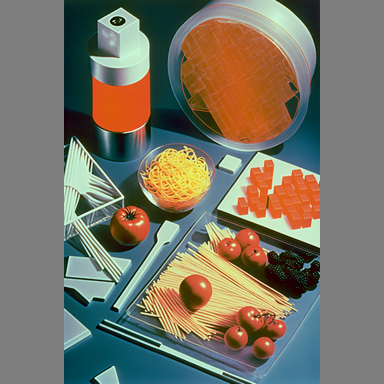

In [7]:
from torchvision.transforms import ToPILImage
x = (pixel_values[5] + 1) / 2

ToPILImage()(x)

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from janus.models import VLChatProcessor
from omegaconf import OmegaConf
import torchvision
import torch

config = OmegaConf.load("/data1/jjc/codebase/one_janus/config/vit_pixel_decoder.yaml")
processor = VLChatProcessor.from_pretrained("/data1/ckpts/deepseek-ai_/Janus-Pro-1B").image_processor
imagenet_transform_train = lambda x: processor(images=[x], return_tensors="pt").pixel_values[0]

imagenet_data_train = torchvision.datasets.ImageFolder(config.data.train_path, transform=imagenet_transform_train)

In [15]:
dataloader = torch.utils.data.DataLoader(
    imagenet_data_train,
    batch_size  = config.data.batch_size,
    shuffle     = True,
    num_workers = config.data.num_workers,
    drop_last   = True,
)

In [16]:
for batch in dataloader:
    x, y = batch
    print(x.shape)
    break

torch.Size([8, 3, 384, 384])


In [ ]:
dataloader